In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.datasets import load_diabetes, fetch_california_housing, fetch_openml
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# **Random Data**


Model Performance Metrics:
--------------------------------------------------

Degree 1:
R-squared: 0.7041
MSE: 14.5109

Degree 2:
R-squared: 0.9986
MSE: 0.0698

Degree 3:
R-squared: 0.9986
MSE: 0.0696

Degree 4:
R-squared: 0.9986
MSE: 0.0696

Degree 5:
R-squared: 0.9986
MSE: 0.0695


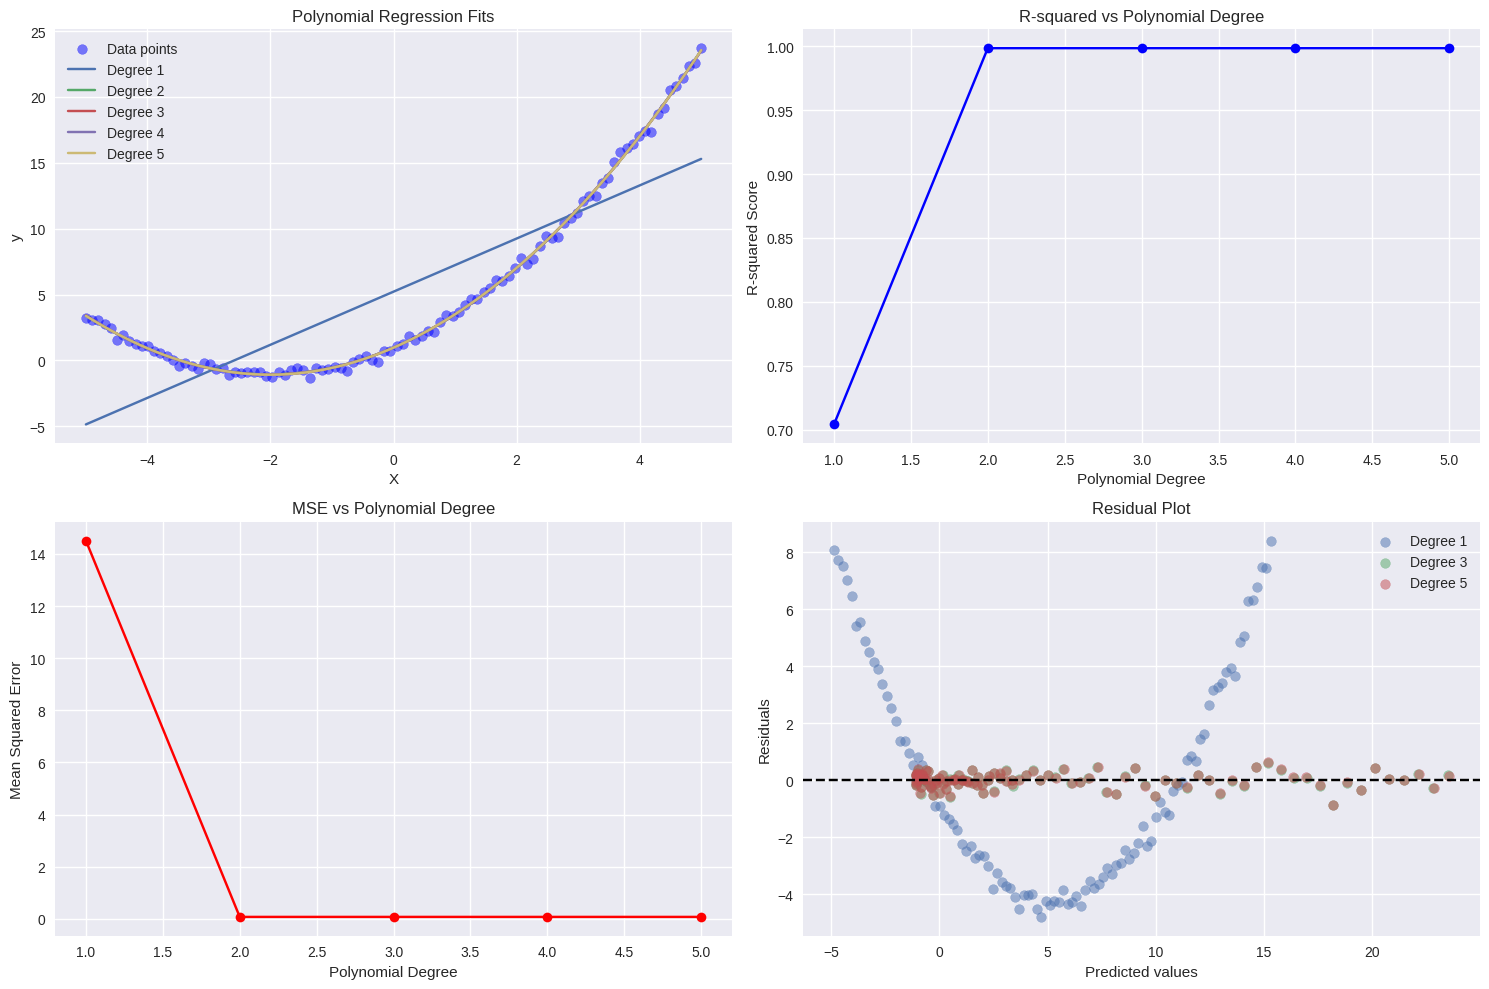

In [31]:


class PolynomialRegressionVisualizer:
    def __init__(self, max_degree=5):
        self.max_degree = max_degree
        self.models = {}
        self.scores = {}

    def generate_data(self, n_samples=100, noise=0.1):
        """Generate synthetic data with polynomial relationship"""
        X = np.linspace(-5, 5, n_samples)
        y = 1 + 2*X + 0.5*X**2 + noise*np.random.randn(n_samples)
        return X.reshape(-1, 1), y

    def fit_models(self, X, y):
        """Fit polynomial regression models of different degrees"""
        for degree in range(1, self.max_degree + 1):
            poly_features = PolynomialFeatures(degree=degree, include_bias=False)
            X_poly = poly_features.fit_transform(X)

            model = LinearRegression()
            model.fit(X_poly, y)

            self.models[degree] = (poly_features, model)

            # Calculate scores
            y_pred = model.predict(X_poly)
            self.scores[degree] = {
                'r2': r2_score(y, y_pred),
                'mse': mean_squared_error(y, y_pred)
            }

    def plot_results(self, X, y):
        """Create comprehensive visualization of results"""
        fig = plt.figure(figsize=(15, 10))

        # Plot 1: Data and fits
        plt.subplot(2, 2, 1)
        plt.scatter(X, y, color='blue', alpha=0.5, label='Data points')

        X_continuous = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
        for degree in self.models:
            poly_features, model = self.models[degree]
            X_poly = poly_features.transform(X_continuous)
            y_pred = model.predict(X_poly)
            plt.plot(X_continuous, y_pred, label=f'Degree {degree}')

        plt.title('Polynomial Regression Fits')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.legend()

        # Plot 2: R-squared scores
        plt.subplot(2, 2, 2)
        degrees = list(self.scores.keys())
        r2_scores = [self.scores[d]['r2'] for d in degrees]
        plt.plot(degrees, r2_scores, 'bo-')
        plt.title('R-squared vs Polynomial Degree')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('R-squared Score')
        plt.grid(True)

        # Plot 3: MSE scores
        plt.subplot(2, 2, 3)
        mse_scores = [self.scores[d]['mse'] for d in degrees]
        plt.plot(degrees, mse_scores, 'ro-')
        plt.title('MSE vs Polynomial Degree')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('Mean Squared Error')
        plt.grid(True)

        # Plot 4: Residuals
        plt.subplot(2, 2, 4)
        for degree in [1, 3, 5]:
            poly_features, model = self.models[degree]
            X_poly = poly_features.transform(X)
            y_pred = model.predict(X_poly)
            residuals = y - y_pred
            plt.scatter(y_pred, residuals, alpha=0.5, label=f'Degree {degree}')

        plt.axhline(y=0, color='k', linestyle='--')
        plt.title('Residual Plot')
        plt.xlabel('Predicted values')
        plt.ylabel('Residuals')
        plt.legend()

        plt.tight_layout()
        return fig

# Example usage
def run_visualization():
    # Create visualizer instance
    viz = PolynomialRegressionVisualizer(max_degree=5)

    # Generate synthetic data
    X, y = viz.generate_data(n_samples=100, noise=0.3)

    # Fit models
    viz.fit_models(X, y)

    # Create visualization
    fig = viz.plot_results(X, y)

    # Print model performance metrics
    print("\nModel Performance Metrics:")
    print("-" * 50)
    for degree in viz.scores:
        print(f"\nDegree {degree}:")
        print(f"R-squared: {viz.scores[degree]['r2']:.4f}")
        print(f"MSE: {viz.scores[degree]['mse']:.4f}")

if __name__ == "__main__":
    run_visualization()

# **'california', 'diabetes', 'ames' Dataset**


Analysis for CALIFORNIA dataset:
--------------------------------------------------


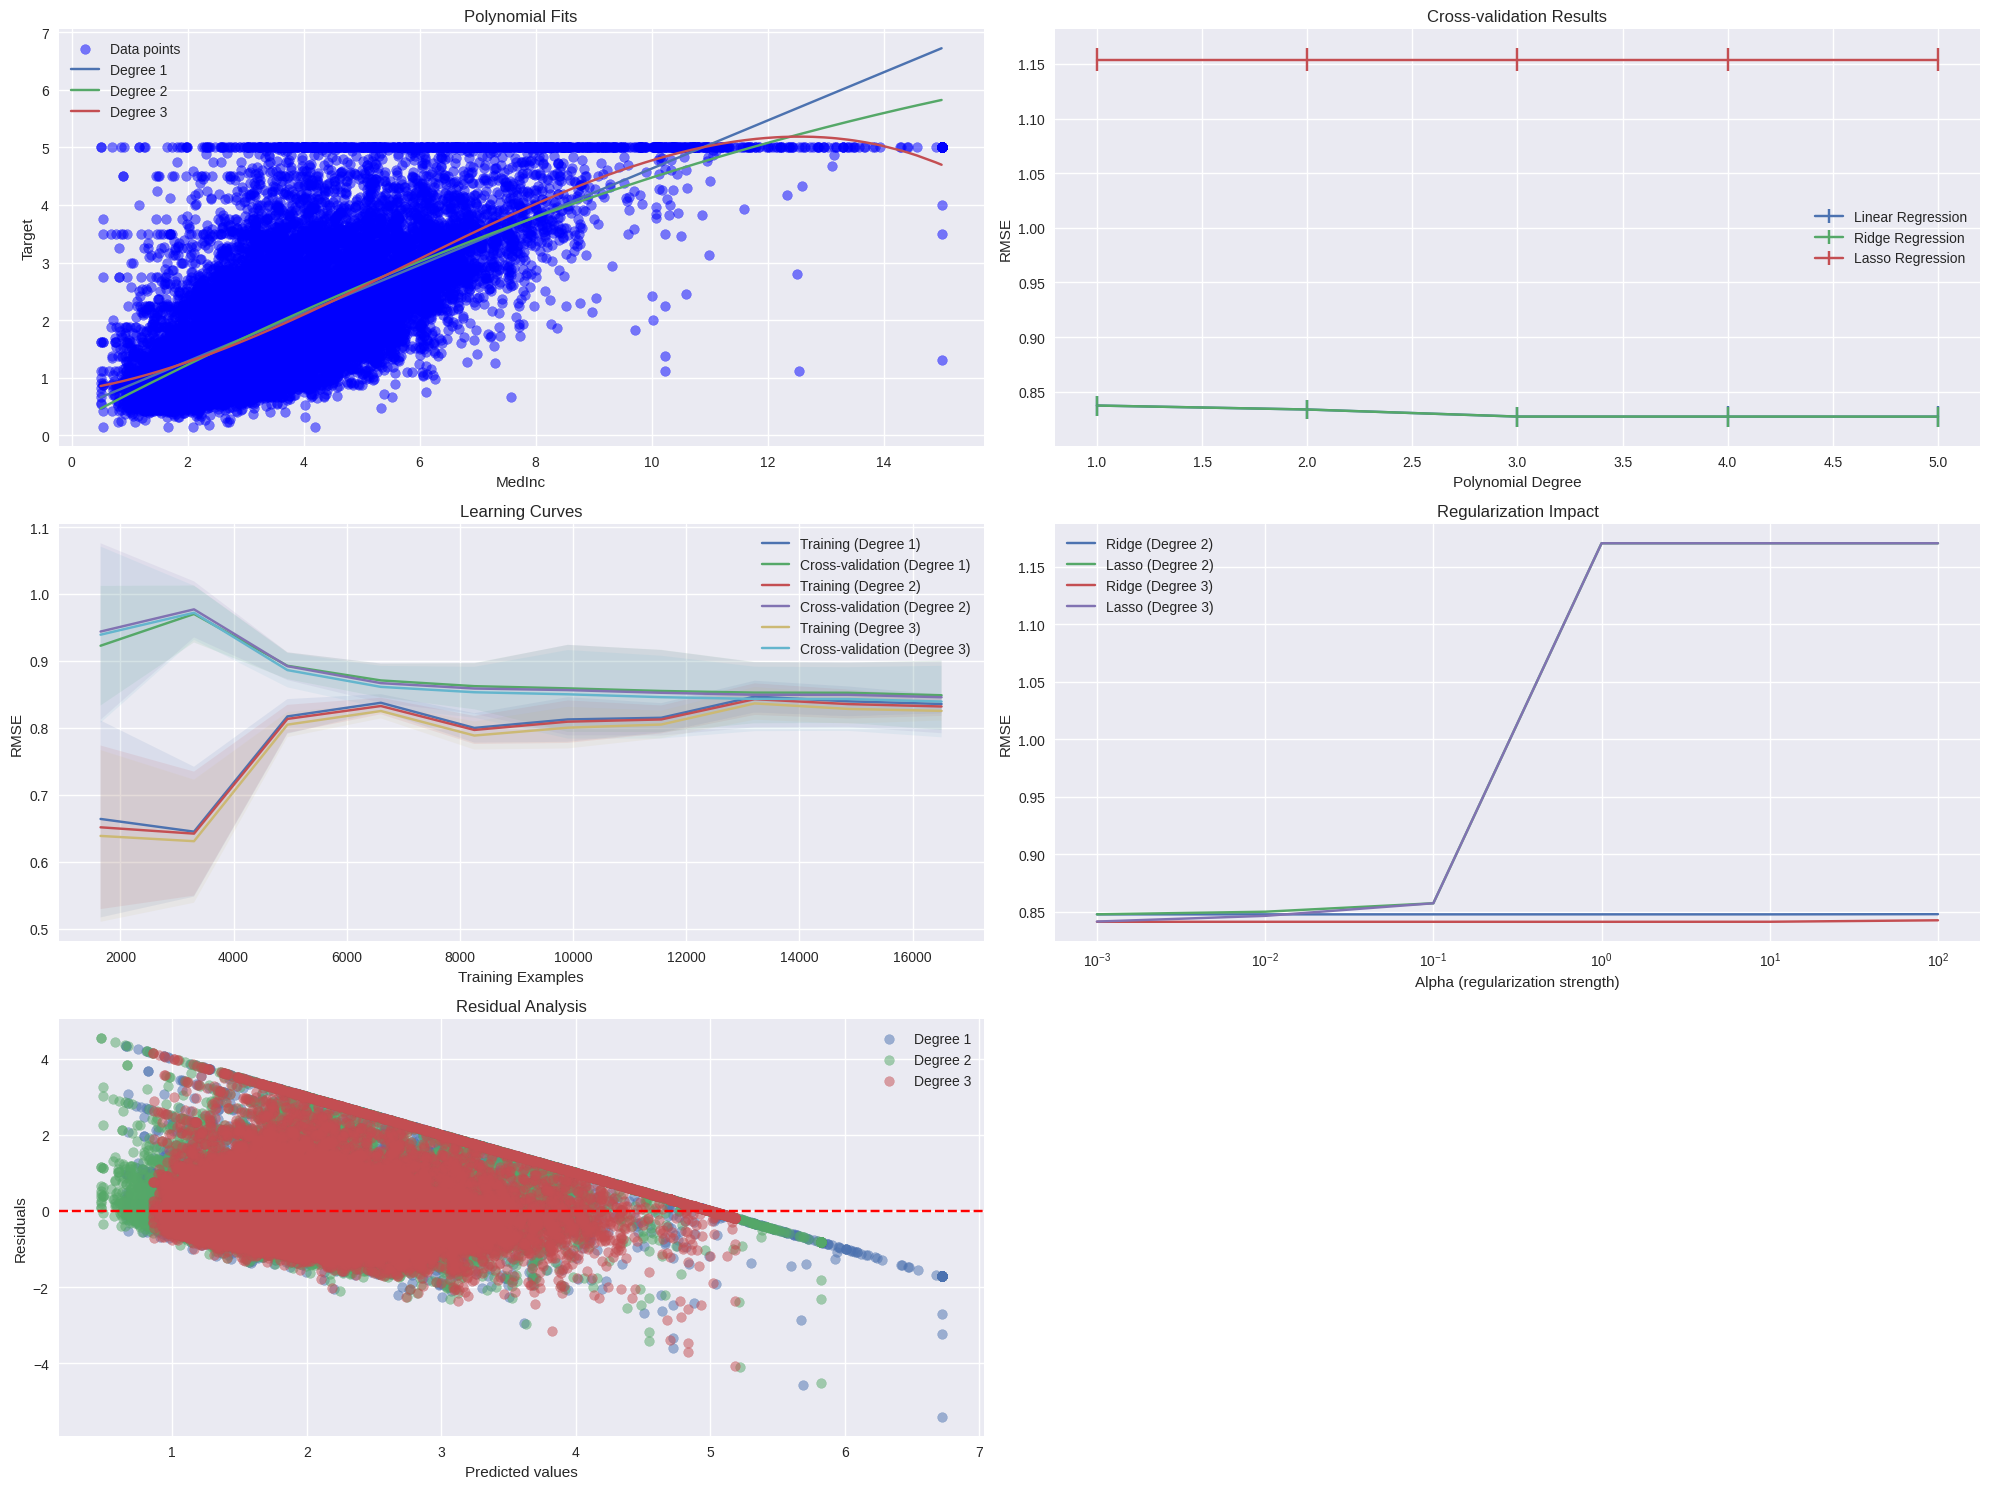


Analysis for DIABETES dataset:
--------------------------------------------------


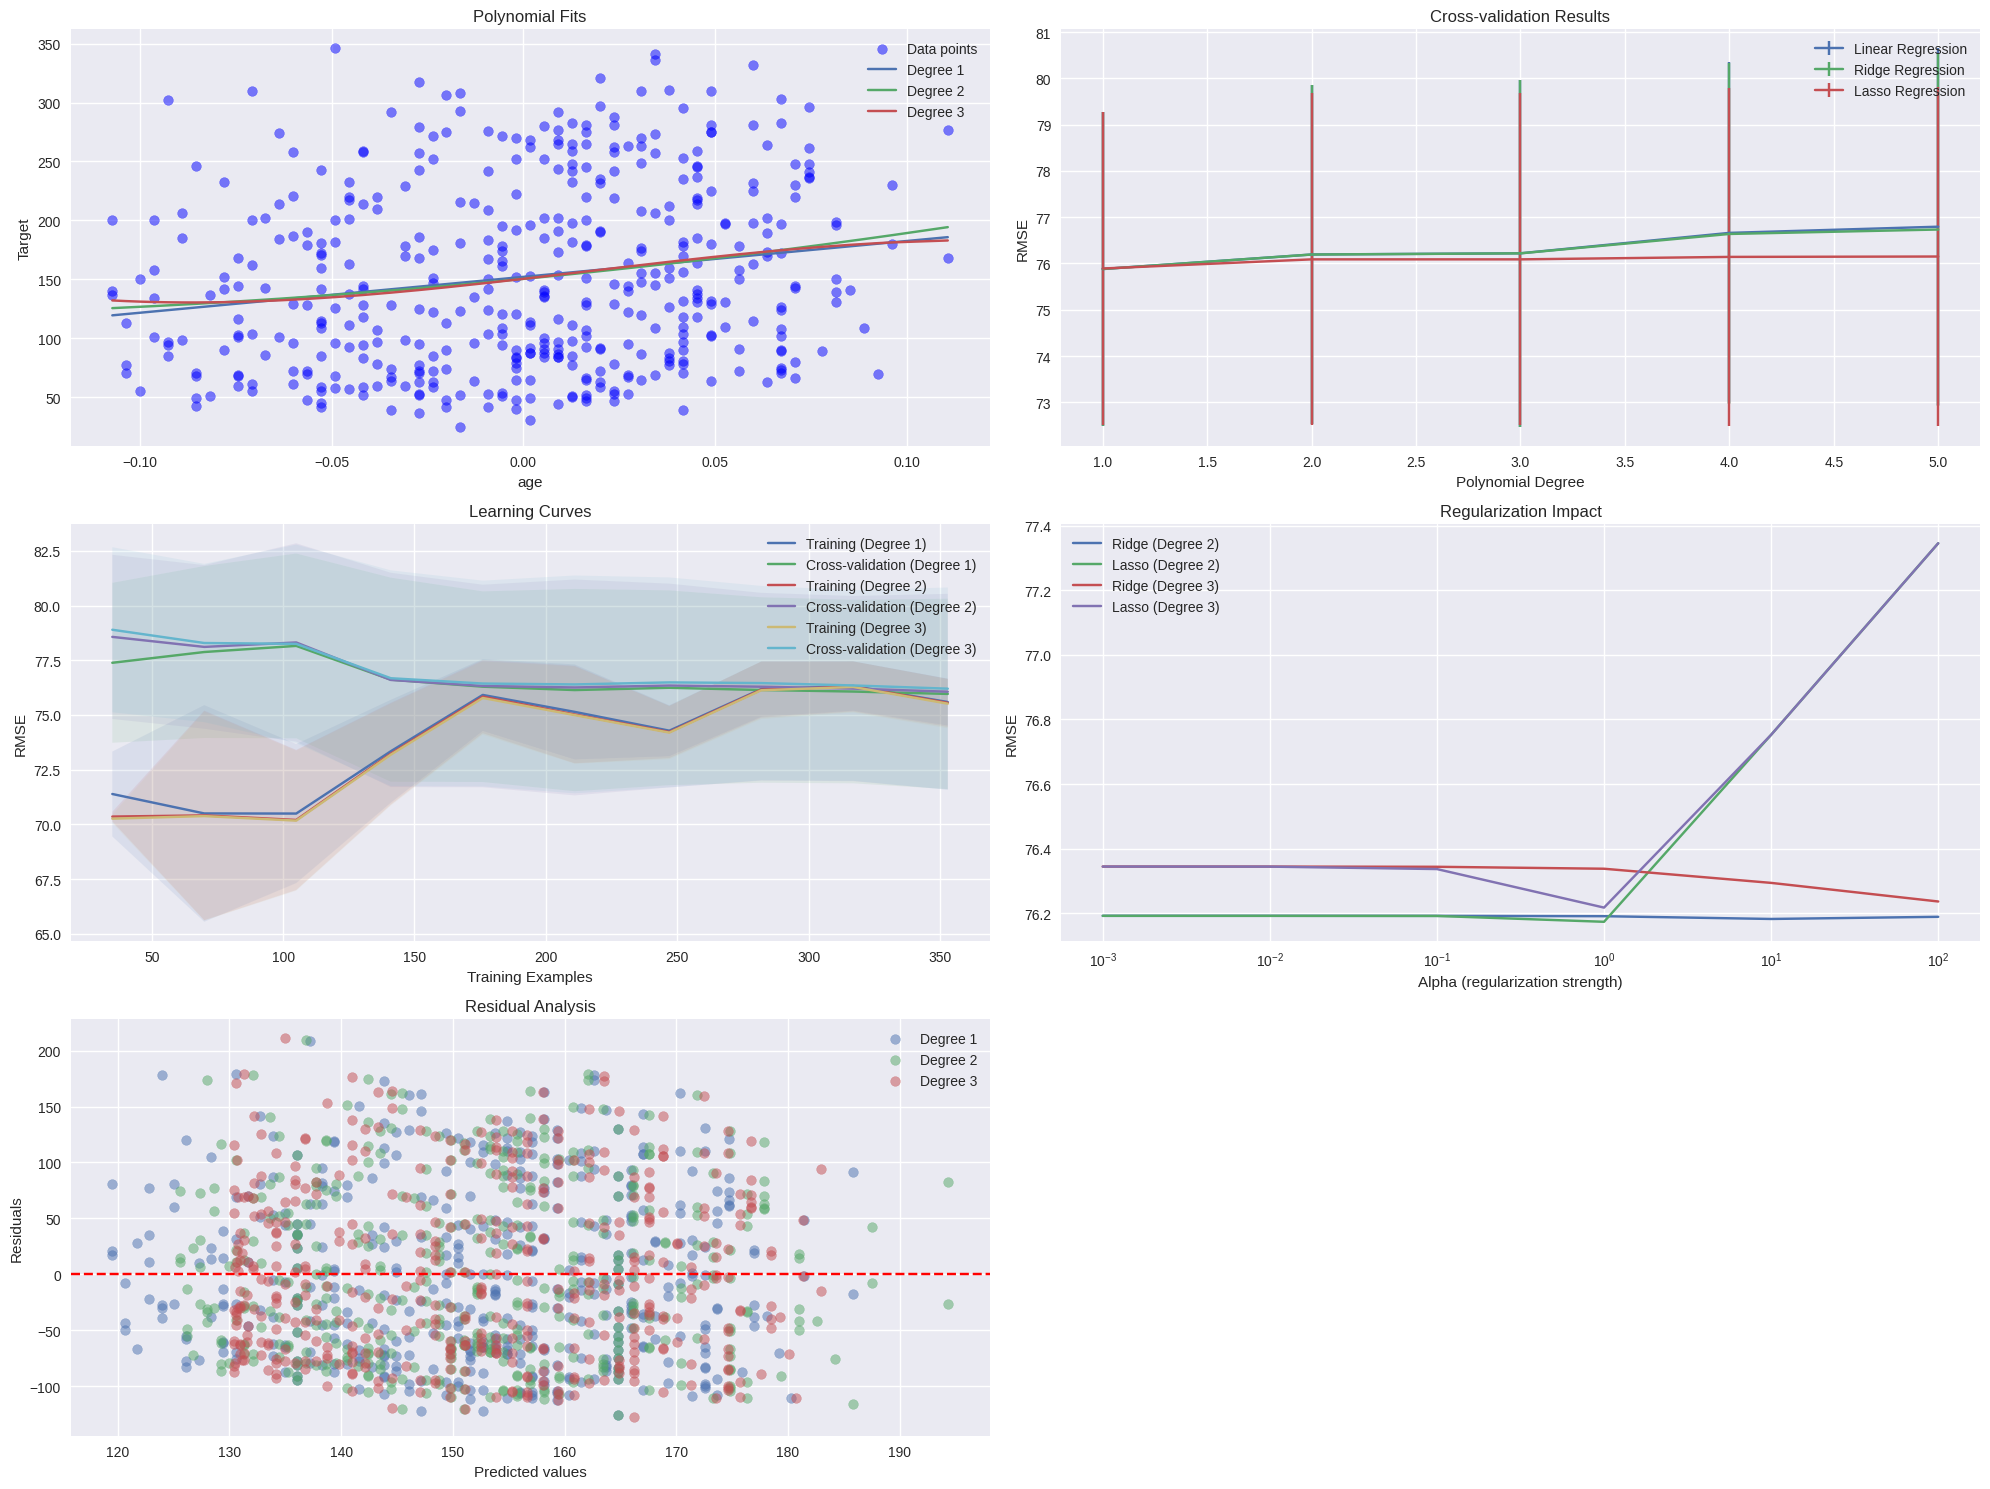


Analysis for AMES dataset:
--------------------------------------------------


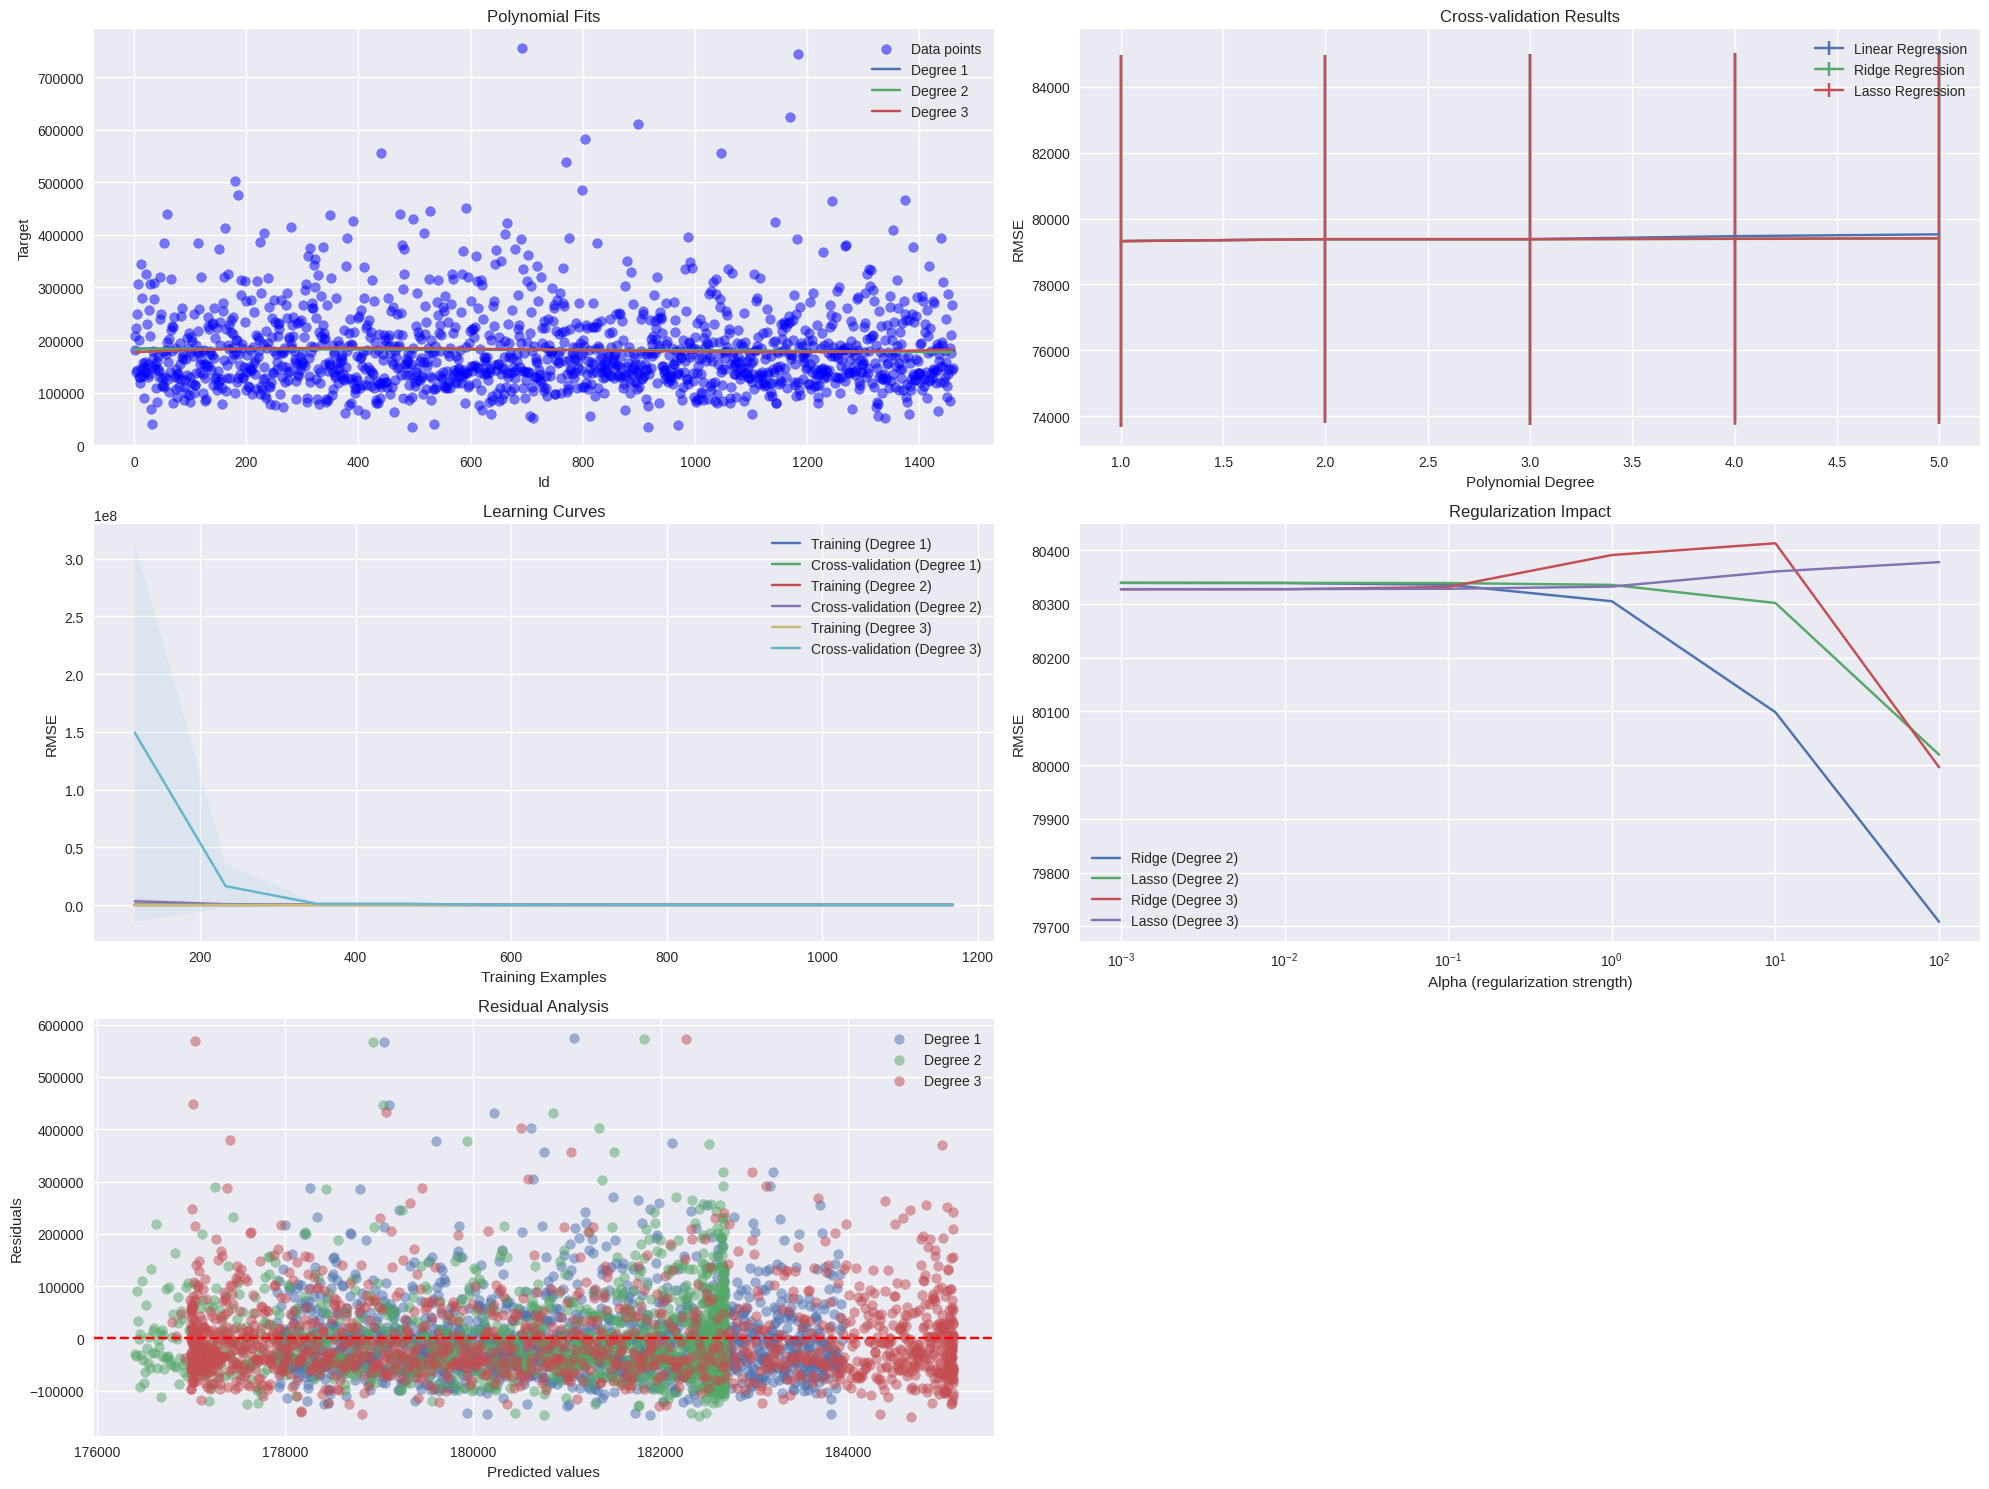

In [32]:


class AdvancedPolynomialRegression:
    def __init__(self, max_degree=5, cv_folds=5, random_state=42):
        self.max_degree = max_degree
        self.cv_folds = cv_folds
        self.random_state = random_state
        self.models = {}
        self.pipelines = {}
        self.cv_results = {}
        self.learning_curves = {}

    def load_dataset(self, dataset_name='california', feature_idx=None):

        if dataset_name == 'california':
            data = fetch_california_housing()
            feature_names = data.feature_names
        elif dataset_name == 'diabetes':
            data = load_diabetes()
            feature_names = data.feature_names
        elif dataset_name == 'ames':
            data = fetch_openml(name='house_prices', version=1, as_frame=True)
            feature_names = data.feature_names
            # Selecting numeric features only for simplicity
            df = data.frame.select_dtypes(include=[np.number])
            df['target'] = data.target
        else:
            raise ValueError("Invalid dataset name")

        df = pd.DataFrame(data.data, columns=feature_names)
        df['target'] = data.target

        if feature_idx is not None:
            X = df.iloc[:, [feature_idx]].values
            feature_name = feature_names[feature_idx]
        else:
            X = df.iloc[:, :-1].values
            feature_name = 'multiple'

        y = df['target'].values

        return X, y, feature_name

    def create_pipeline(self, degree, regularization=None, alpha=1.0):
        """Create pipeline with polynomial features and optional regularization"""
        steps = [
            ('poly', PolynomialFeatures(degree=degree)),
            ('scaler', StandardScaler())
        ]

        if regularization == 'ridge':
            steps.append(('regressor', Ridge(alpha=alpha)))
        elif regularization == 'lasso':
            steps.append(('regressor', Lasso(alpha=alpha)))
        else:
            steps.append(('regressor', LinearRegression()))

        return Pipeline(steps)

    def perform_cross_validation(self, X, y):
        """Perform cross-validation for different polynomial degrees"""
        kf = KFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)

        for degree in range(1, self.max_degree + 1):
            # Create pipelines with different regularization
            self.pipelines[degree] = {
                'linear': self.create_pipeline(degree),
                'ridge': self.create_pipeline(degree, 'ridge', 1.0),
                'lasso': self.create_pipeline(degree, 'lasso', 1.0)
            }

            # Perform cross-validation for each pipeline
            self.cv_results[degree] = {}
            for name, pipeline in self.pipelines[degree].items():
                scores = cross_val_score(pipeline, X, y, cv=kf,
                                      scoring='neg_mean_squared_error')
                rmse_scores = np.sqrt(-scores)

                self.cv_results[degree][name] = {
                    'mean_rmse': rmse_scores.mean(),
                    'std_rmse': rmse_scores.std(),
                    'scores': rmse_scores
                }

    def generate_learning_curves(self, X, y, degrees=[1, 2, 3]):
        """Generate learning curves for specified polynomial degrees"""
        train_sizes = np.linspace(0.1, 1.0, 10)

        for degree in degrees:
            pipeline = self.pipelines[degree]['linear']
            train_sizes_abs, train_scores, test_scores = learning_curve(
                pipeline, X, y, train_sizes=train_sizes, cv=self.cv_folds,
                scoring='neg_mean_squared_error', n_jobs=-1
            )

            self.learning_curves[degree] = {
                'train_sizes': train_sizes_abs,
                'train_scores': np.sqrt(-train_scores),
                'test_scores': np.sqrt(-test_scores)
            }

    def plot_comprehensive_analysis(self, X, y, feature_name):
        """Create comprehensive visualization of all analyses"""
        plt.style.use('seaborn')
        fig = plt.figure(figsize=(20, 15))

        # Plot 1: Data and polynomial fits
        plt.subplot(3, 2, 1)
        if X.shape[1] == 1:
            plt.scatter(X, y, color='blue', alpha=0.5, label='Data points')
            X_sorted = np.sort(X, axis=0)

            for degree in [1, 2, 3]:
                pipeline = self.pipelines[degree]['linear']
                y_pred = pipeline.fit(X, y).predict(X_sorted)
                plt.plot(X_sorted, y_pred, label=f'Degree {degree}')

            plt.xlabel(feature_name)
            plt.ylabel('Target')
            plt.title('Polynomial Fits')
            plt.legend()

        # Plot 2: Cross-validation results
        plt.subplot(3, 2, 2)
        degrees = list(self.cv_results.keys())
        for name in ['linear', 'ridge', 'lasso']:
            mean_rmse = [self.cv_results[d][name]['mean_rmse'] for d in degrees]
            std_rmse = [self.cv_results[d][name]['std_rmse'] for d in degrees]

            plt.errorbar(degrees, mean_rmse, yerr=std_rmse,
                        label=f'{name.capitalize()} Regression')

        plt.xlabel('Polynomial Degree')
        plt.ylabel('RMSE')
        plt.title('Cross-validation Results')
        plt.legend()

        # Plot 3: Learning curves
        plt.subplot(3, 2, 3)
        for degree in self.learning_curves:
            curves = self.learning_curves[degree]
            train_mean = curves['train_scores'].mean(axis=1)
            train_std = curves['train_scores'].std(axis=1)
            test_mean = curves['test_scores'].mean(axis=1)
            test_std = curves['test_scores'].std(axis=1)

            plt.fill_between(curves['train_sizes'],
                           train_mean - train_std,
                           train_mean + train_std,
                           alpha=0.1)
            plt.fill_between(curves['train_sizes'],
                           test_mean - test_std,
                           test_mean + test_std,
                           alpha=0.1)
            plt.plot(curves['train_sizes'], train_mean,
                    label=f'Training (Degree {degree})')
            plt.plot(curves['train_sizes'], test_mean,
                    label=f'Cross-validation (Degree {degree})')

        plt.xlabel('Training Examples')
        plt.ylabel('RMSE')
        plt.title('Learning Curves')
        plt.legend(loc='best')

        # Plot 4: Regularization comparison
        plt.subplot(3, 2, 4)
        alphas = [0.001, 0.01, 0.1, 1, 10, 100]
        degrees_to_test = [2, 3]

        for degree in degrees_to_test:
            ridge_rmse = []
            lasso_rmse = []

            for alpha in alphas:
                # Ridge
                ridge_pipe = self.create_pipeline(degree, 'ridge', alpha)
                ridge_scores = cross_val_score(ridge_pipe, X, y, cv=self.cv_folds,
                                            scoring='neg_mean_squared_error')
                ridge_rmse.append(np.sqrt(-ridge_scores.mean()))

                # Lasso
                lasso_pipe = self.create_pipeline(degree, 'lasso', alpha)
                lasso_scores = cross_val_score(lasso_pipe, X, y, cv=self.cv_folds,
                                            scoring='neg_mean_squared_error')
                lasso_rmse.append(np.sqrt(-lasso_scores.mean()))

            plt.plot(alphas, ridge_rmse,
                    label=f'Ridge (Degree {degree})')
            plt.plot(alphas, lasso_rmse,
                    label=f'Lasso (Degree {degree})')

        plt.xscale('log')
        plt.xlabel('Alpha (regularization strength)')
        plt.ylabel('RMSE')
        plt.title('Regularization Impact')
        plt.legend()

        # Plot 5: Residual analysis
        plt.subplot(3, 2, 5)
        for degree in [1, 2, 3]:
            pipeline = self.pipelines[degree]['linear']
            y_pred = pipeline.fit(X, y).predict(X)
            residuals = y - y_pred

            plt.scatter(y_pred, residuals, alpha=0.5, label=f'Degree {degree}')

        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted values')
        plt.ylabel('Residuals')
        plt.title('Residual Analysis')
        plt.legend()

        plt.tight_layout()
        plt.show()

# List of datasets to loop over
datasets = ['california', 'diabetes', 'ames']

# Loop through each dataset and apply the same operations
for dataset_name in datasets:
    print(f"\nAnalysis for {dataset_name.upper()} dataset:")
    print("-" * 50)
    model = AdvancedPolynomialRegression(max_degree=5, cv_folds=5)
    X, y, feature_name = model.load_dataset(dataset_name, feature_idx=0)  # 0 for first feature
    model.perform_cross_validation(X, y)
    model.generate_learning_curves(X, y, degrees=[1, 2, 3])
    model.plot_comprehensive_analysis(X, y, feature_name)



# **Wine Quality Dataset And Concrete Strength Dataset**

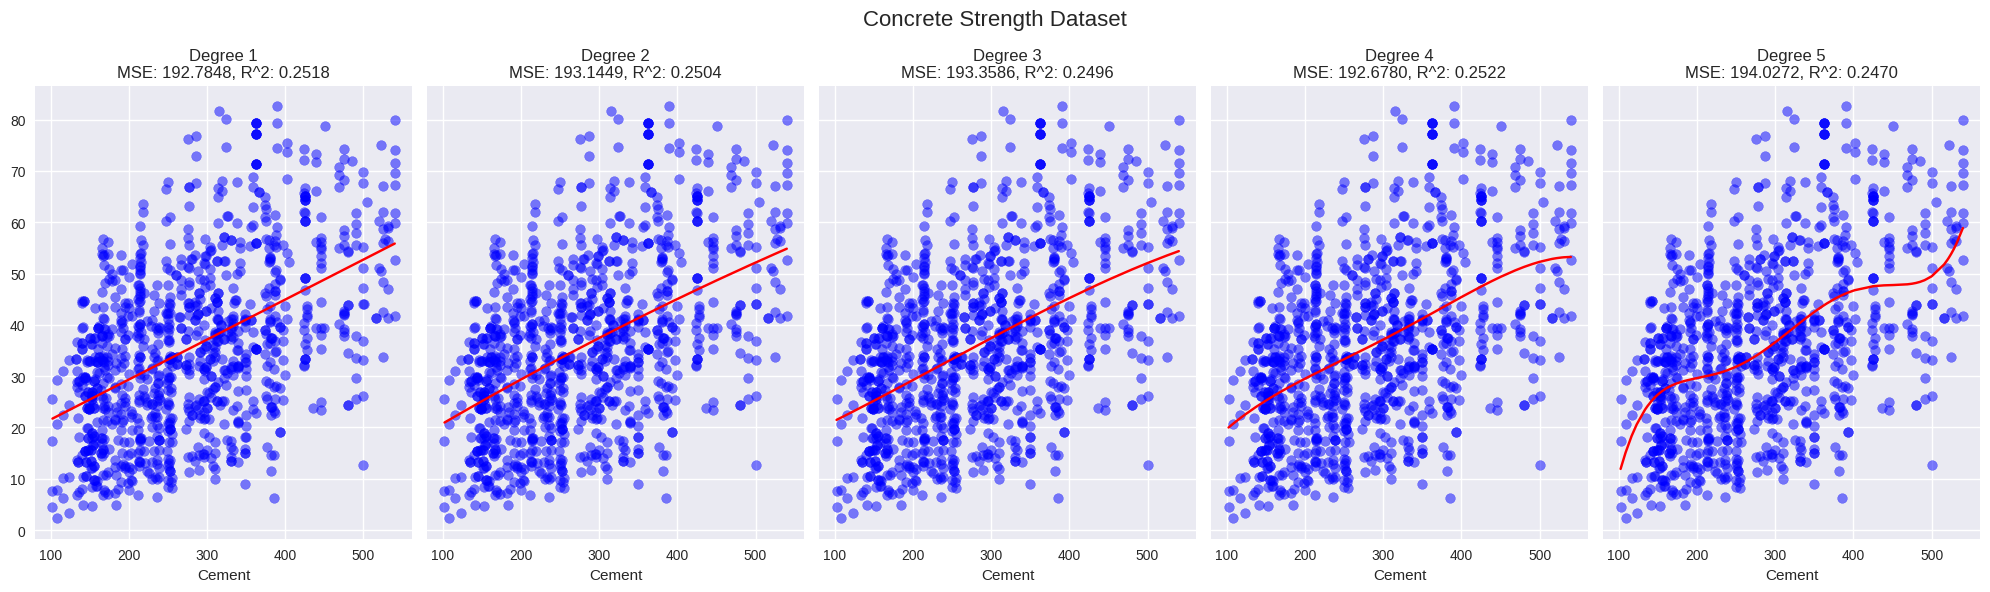

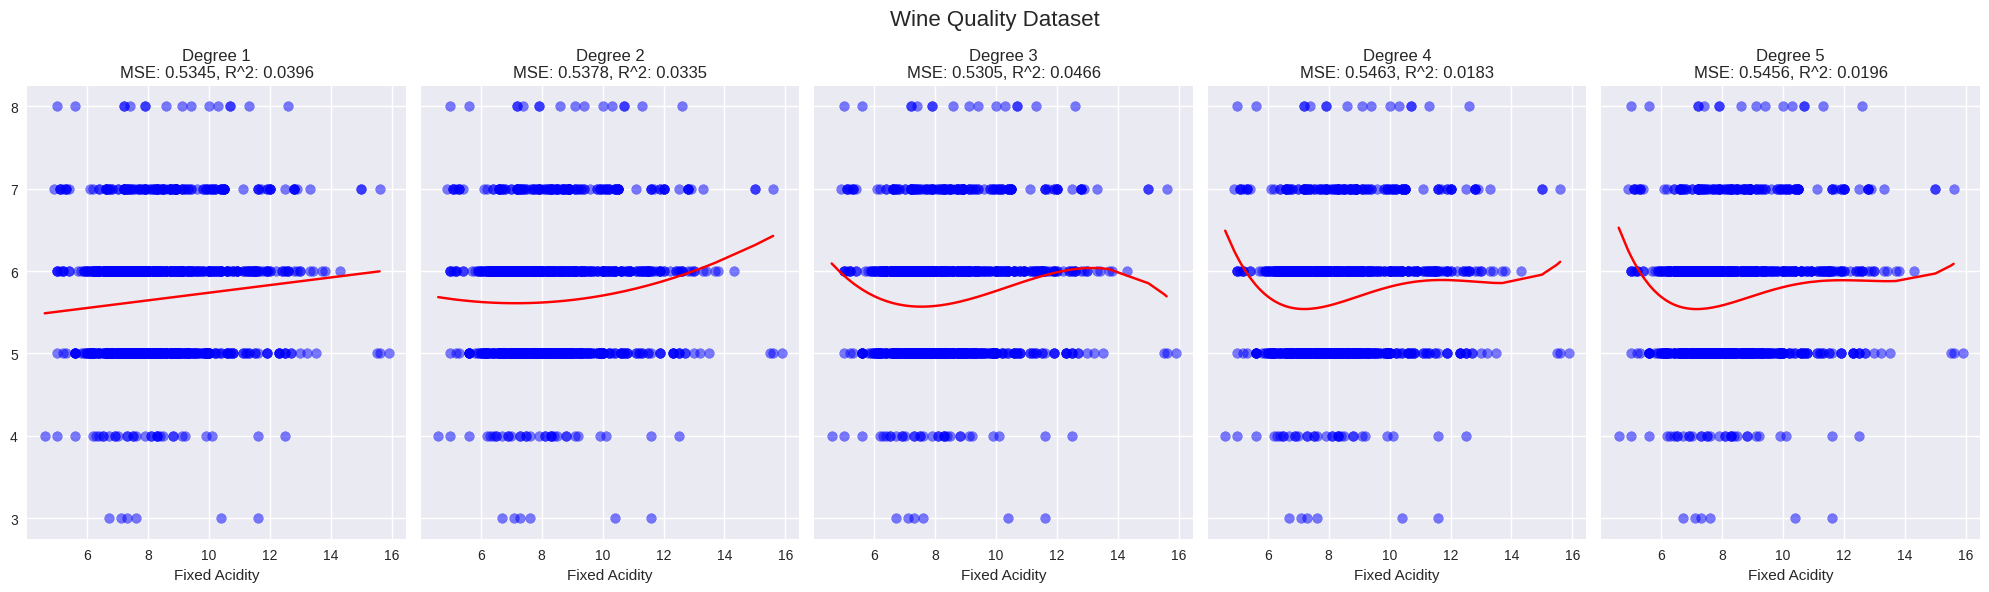

In [33]:


# Function to perform polynomial regression and return plot data
def polynomial_regression(X, y, degree):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    # Fit the Polynomial Regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_poly)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Return the necessary values for plotting
    return X_train, model, poly_features, mse, r2

# Function to plot all results in one horizontal plot
def plot_all_datasets(X, y, title, feature_name, target_name, degrees):
    fig, axes = plt.subplots(1, len(degrees), figsize=(20, 6), sharey=True)

    for i, degree in enumerate(degrees):
        X_train, model, poly_features, mse, r2 = polynomial_regression(X, y, degree)
        axes[i].scatter(X, y, color="blue", alpha=0.5, label="Data")
        axes[i].plot(np.sort(X_train.values, axis=0),
                     model.predict(poly_features.transform(np.sort(X_train.values, axis=0))),
                     color="red", label=f"Degree {degree}")
        axes[i].set_title(f"Degree {degree}\nMSE: {mse:.4f}, R^2: {r2:.4f}")
        axes[i].set_xlabel(feature_name)

    plt.suptitle(f"{title}", fontsize=16)
    plt.tight_layout()
    plt.show()

# 1. Concrete Strength Dataset
concrete_data = pd.read_csv("concrete_data.csv")
X_concrete = concrete_data[['Cement']]  # Use only 'Cement' as a feature for visualization
y_concrete = concrete_data['Strength']  # Target (compressive strength)

# Plot for degrees 1 to 5
plot_all_datasets(X_concrete, y_concrete, title="Concrete Strength Dataset", feature_name='Cement', target_name='Strength', degrees=range(1, 6))

# 2. Wine Quality Dataset
wine_data = pd.read_csv("WineQT.csv")
X_wine = wine_data[['fixed acidity']]  # Use 'fixed acidity' as a feature
y_wine = wine_data['quality']  # Target (quality)

# Plot for degrees 1 to 5
plot_all_datasets(X_wine, y_wine, title="Wine Quality Dataset", feature_name='Fixed Acidity', target_name='Quality', degrees=range(1, 6))


# **Energy Efficiency Dataset**

Degree 2 - Mean Squared Error: 44.3434, R^2 Score: 0.5746
Cross-validated MSE (5-fold): 41.8710


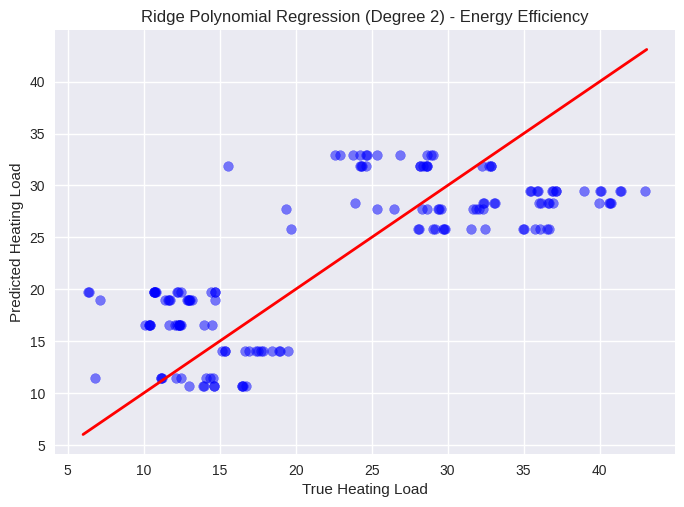

In [34]:


# Load the Energy Efficiency Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
energy_data = pd.read_excel(url)

# Select relevant features for simplicity (relative compactness and surface area) and target (Heating Load)
X = energy_data[['X1', 'X2']]  # X1: Relative Compactness, X2: Surface Area
y = energy_data['Y1']  # Y1: Heating Load

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features
degree = 2  # Can try higher degrees as well
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Apply Ridge regression (Regularization)
ridge_model = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge_model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Degree {degree} - Mean Squared Error: {mse:.4f}, R^2 Score: {r2:.4f}")

# Cross-validation (k-fold)
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(ridge_model, poly.fit_transform(X), y, cv=kfold, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE (5-fold): {-np.mean(cv_scores):.4f}")

# Visualize the results (scatter plot)
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2)  # Diagonal line for comparison
plt.xlabel('True Heating Load')
plt.ylabel('Predicted Heating Load')
plt.title(f"Ridge Polynomial Regression (Degree {degree}) - Energy Efficiency")
plt.show()
